# Local Classifier 2 Sample Tests (C2ST) for conditional Normalizing Flows 


## Context & Objective
We consider a **conditional target density** $p(\theta \mid x)$ and **samples from the joint p.d.f** $\{\theta_i, x_i\} \sim p(\theta, x)$.

Our estimator is a **conditional Normalizing Flow** $q_{\phi}$ with base distribution $p(z) = \mathcal{N}(0,\mathbf{1}_m)$ and bijective transormation $T_{\phi}(.; x)$ defined on $\mathbb{R}^m$ and for all $x \in \mathbb{R}^d$.
    
- Its density can be explicilty evaluated using the inverse transformation:
    $$
    \forall \theta \in \mathbb{R}^m, \quad q_{\phi}(\theta \mid x) = p_{\mathcal{N}(0,\mathbf{1}_m)}(T_{\phi}^{-1}(\theta; x))\left|\operatorname{det} J_{T_{\phi}^{-1}}(\theta; x)\right|
    $$
    which means that flow can be trained via MLE on $N_1$ samples from the joint: 
$$\{\theta_i, x_i\}_{i=1}^{N_1} \sim p(\theta, x) \quad \rightarrow \quad \min_{\phi} -\frac{1}{N_1}\sum_{i=1}^N \log[q_{\phi}(\theta_i \mid x_i)] = -\frac{1}{N_1}\sum_{i=1}^N \log[p_{\mathcal{N}(0,\mathbf{1}_m)}(T_{\phi}^{-1}(\theta_i; x_i))\left|\operatorname{det} J_{T_{\phi}^{-1}}(\theta_i; x_i)\right|]$$

- We can sample from it using the forward transformation:
    $$z_i\sim p(z) = \mathcal{N}(0,\mathbf{1}_m) \quad \rightarrow \quad \theta^{\phi; x}_i = T_{\phi}(z_i; x)\sim q_{\phi}(\theta \mid x)$$
**GOAL:** Evaluate the ***local consistency of our estimator***, i.e. whether the following local null hypothesis holds for a fixed $x \in \mathbb{R}^d$
$$\mathcal{H}_0(x): p(\theta \mid x) = q_{\phi}(\theta \mid x), \quad \forall \theta \in \mathbb{R}^m$$



## Methodology 
**THEOREM: Local Consistency for NFs.** 
The local null hypothesis holds if, and only if, the inverse flow transformation applied to the target distribution recovers the base distribution. 

Using the same definition for $q_{\phi}$ as during sampling, $q_{\phi}(\theta \mid x) = p(T_{\phi}(z; x))$ (c.f. $T_{\phi}(z; x) \sim q_{\phi}(\theta \mid x)$ for $z\sim p(z)$), we have:
$$ p(\theta \mid x) = q_{\phi}(\theta \mid x) \iff p(T_{\phi}^{-1}(\theta; x)\mid x) = p(T_{\phi}^{-1}(T_{\phi}(z; x); x)) = p(z) = \mathcal{N}(0,\mathbf{1}_m)$$

**METHOD: Local C2ST.** 
We have a calibration dataset with $N_2$ samples from the joint $\{\theta_i, x_i\}_{i=1}^{N_2}$ (different than the data used to train the flow!)
1. Compute inverse flow-transformation: $T^{-1}_{\phi}(\theta_i,x_i)$

2. **Train classifier** to discriminate between the joint distributions $p(T^{-1}_{\phi}(\theta,x),x) = p(T^{-1}_{\phi}(\theta,x)\mid x)p(x)$ and $\mathcal{N}(0,1)p(x)$. This is a binary classification problem with 
    - **features** $[Z_i, x_i]$
    - **labels**: $Y = 0$, if $Z_i \sim \mathcal{N}(0,\mathbf{1}_m)$, $\quad Y=1$, if $Z_i = T^{-1}_{\phi}(\theta_i, x_i)$
    
3. **Evaluate consistency** for a given $x_0$, i.e. test whether $\mathcal{H}_0(x_0)$ holds: 
    
    - We evaluate the distribution of the predictive probability of belonging to class $0$ (normal distribution) $\hat{p}(Y=0\mid z,x_0)$ for $z\sim \mathcal{N}(0,\mathbf{1}_m)$ and fixed $x=x_0$: 
        - draw $z_i \sim \mathcal{N}(0,\mathbf{1}_m), i \in [1,N]$, 
        - evaluate the predictive probability of the trained classifier in the features $[z_i, x_0]$ (e.g. with the function `predict_proba` for `scikit-learn`-classifiers), 
        - ouput: a vector of samples $[\hat{p}(Y=0\mid z_1,x_0), \dots, \hat{p}(Y=0\mid z_N,x_0)]$ from the wanted distribution.
    
    - Under $\mathcal{H}_0(x_0)$, the discriminator should be completely uncertain about the predictive class, i.e. the predtictive probability should always be $0.5$, i.e. the distribution of the predictive probability (at $x_0$) should be a **dirac around $0.5$** (will be larger if not enough training samples, as unlikely datapoints that would not be covered by the training dataset could be considered out-of-distribution). 
    - Visualization:
        - histograms
        - PP-plots: c.d.f of the predicted probas vs. c.d.f of the dirac (step function)
    - Test statistics: 
        - total variation distance (TV_dist): euclidean distance between c.d.fs of predicted probas and dirac (step function)
        - wasserstein distance (w_dist) between dirac and predicted probas 

**Questions:**
- mathematical proof of the necessary and sufficient condition of the c2st test? 
- how to interpret the pp-plots of the predicted probabilities: what deviances from dirac indicate bias/dispersion? 

## Numerical illustration in 1D

In [1]:
# import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os

import sys
sys.path.remove('/data/parietal/store/work/jlinhart/git_repos/HNPE')
sys.path.append('../../valDiags_flows/')

### Target density and Data Generation: 
Our target density is a 1D conditional gaussian ($m=1, d=2$):
$$p(\theta\mid x) = \mathcal{N}(x_1+x_2, 1), \quad x = (x_1, x_2) \sim \mathcal{N}(\mu, \Sigma)$$
where $\mu = [0, 0]$ and $\Sigma = \begin{pmatrix} 1 & 0.8\\ 0.8 & 1 \end{pmatrix}$.

This toy example is taken from [Zhao et al. (2021)].
Here, the "true" target distribution is exactly known: for any fixed $x_0 \in \mathbb{R}^2$ we can directly get samples $\theta_{x_0} \sim p(\theta \mid x_0) = \mathcal{N}(x_{0,1} + x_{0,2}, 1)$. Note however, that this is only used as a ground-truth reference: the density estimators (resp. validation metrics) are still being trained (resp. computed) on a dataset from the joint $\{\theta, x\} \sim p(\theta, x)$.

We chose this example to directly analyse the sensibility of validation diagnostics of conditional density estimators w.r.t. the context variable $x$, without any other influences on the result (e.g. introduced by the prior in SBI-context). 

Indeed, conditional density estimators can be valid on average over the $x$-space (global consistency), but be a bad approximators of the target distribution $p(\theta \mid x_0)$ at a specific location $x_0$ (local consistency). As done by [Zhao et al. (2021)] with the PIT, we will show that the vanilla C2ST, which only allows to measure global consistency, is invariant to covariate transforms in the $x$-space, whereas the proposed method ***local C2ST*** allows to detect the resulting local inconsistencies.

*Comment: this toy example is chosen outside of the SBI context* 
- *the simulator parameters $(\mu, \Sigma)$ are not what we want to estimate, i.e. the target variable $\theta$,*
- *there is no prior on the parameters $\theta$,*
- *the target distribution is not a posterior, just a "normal" conditional density (defined as a function of $x$)*

In [2]:
from data.data_generators import ConditionalGaussian1d

# Define Data Generator: 1D conditional gaussian
data_gen = ConditionalGaussian1d(mu=[0,0], sigma=[1,1], rho=0.8)

# Get train, cal and test datasets:
# - train samples are used to train the flow,
# - cal samples are used to learn the (unknown) PIT-distributions
# - test samples are used to evaluate the known and learned PIT-distributions 

train_size = 10_000  
cal_size = 5_000  
test_size = 1_000  

filename = '../saved_experiments/Gaussian1d/datasets.pkl'
if os.path.exists(filename):
    dataset = torch.load(filename)
    x_train, theta_train = dataset['train']
    x_cal, theta_cal = dataset['cal']
    x_test, theta_test = dataset['test']
else:
    x_train, theta_train = data_gen.get_joint_data(n=train_size)
    x_cal, theta_cal = data_gen.get_joint_data(n=cal_size)
    x_test, theta_test = data_gen.get_joint_data(n=test_size)
    dataset = {'train': [x_train, theta_train], 'cal': [x_cal, theta_cal], 'test': [x_test, theta_test]}
    torch.save(dataset, filename)

print("NB training samples: ", x_train.shape)
print("NB calibration samples: ", x_cal.shape)
print("NB test samples: ", x_test.shape)

NB training samples:  torch.Size([10000, 2])
NB calibration samples:  torch.Size([5000, 2])
NB test samples:  torch.Size([1000, 2])


In [3]:
from lampe.data import JointLoader
from lampe.inference import NPE, NPELoss
import torch
import torch.optim as optim
from lampe.utils import GDStep
from itertools import islice
from tqdm import tqdm


prior = data_gen.x_dist
simulator = data_gen.sample_theta

### Density Estimation
We consider two NF-estimators:
- good MAF: trained on the full context variable $X=(X_1, X_2)$
- bad MAF: trained on a non-sufficient context $g(X)=X_1$

We will see that the global consistency check (on average over $x$-space, and not locally at a specific location $x=x_0$) is insensitive to the covariate transforms in $x$-space: Both estimators pass the test. 

The local consistency test however will show that the bad MAF is actually not a good approximation of the target density when evaluated at some fixed location $x=x_0$.

In [4]:
# Define estimator
from data.feature_transforms import first_dim_only

# good estimator trained on full context X=(X_1,X_2)
maf_good = NPE(1, 2, transforms=5, hidden_features=[50])

# bad estimator trained on partial context g(X)=(X_1)
class NPE_BAD(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.npe = NPE(1, 1, transforms=5, hidden_features=[50])
    
    def forward(self, theta: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return self.npe(theta, first_dim_only(x))

    def flow(self, x: torch.Tensor):  # -> Distribution
        return self.npe.flow(first_dim_only(x))


maf_bad = NPE_BAD()

In [5]:
# train estimators 
from nde.train import train_lampe_npe

best_val_loss, nb_epochs = train_lampe_npe(
        maf_good,
        theta_train,
        x_train, 
        num_epochs=200,
        batch_size=100,
        lr=1e-3,
        optimizer=torch.optim.AdamW,
        validation=True,
        epochs_until_converge=20,
        # clip=0.1
    )

best_val_loss_bad, nb_epochs = train_lampe_npe(
        maf_bad,
        theta_train,
        x_train,
        num_epochs=200,
        batch_size=100,
        lr=1e-3,
        optimizer=torch.optim.AdamW,
        validation=True,
        epochs_until_converge=20,
        # clip=0.1
    )

 11%|█         | 22/200 [00:10<01:21,  2.18epoch/s, loss=1.57]


### Evaluation of the trained flows using C2ST 
We use the `MLPClassifier` from `sklearn` with kwargs as specified in `sbi.utils.metrics` and 5000 calibration samples from the joint (this choice is motivated in the last section).

In [11]:
maf_good.eval()
maf_bad.eval()

# Compute the inverse flow transformation on samples from the calibration set 
inv_flow_samples_cal_good = maf_good.flow(x_cal).transform(theta_cal).detach().numpy()
inv_flow_samples_cal_bad = maf_bad.flow(first_dim_only(x_cal)).transform(theta_cal).detach().numpy()

# Generate data from the base / normal distribution 
base_dist_samples = maf_good.flow(x_cal).base.sample()


#### 1. Global Consistency Check
We start by looking at the overall performance of our estimators: c2st score (i.e. cross-val accuracy) for a discrimination task between the inverse-flow distribution $p(T^{-1}_{\phi}(\theta; x))$ over the joint, and $\mathcal{N}(0,1)$. This gives us the expected (average)performance over the $x$-space (and not for a specific location $x_0$). 

In [10]:
# Global test with mlp
from sbi.utils.metrics import c2st_scores
scores_good_gl = c2st_scores(torch.tensor(inv_flow_samples_cal_good), base_dist_samples, n_folds=10)
scores_bad_gl = c2st_scores(torch.tensor(inv_flow_samples_cal_bad), base_dist_samples, n_folds=10)
print('good:', np.mean(scores_good_gl).__round__(2), '+/-', np.std(scores_good_gl).__round__(2))
print('bad:', np.mean(scores_bad_gl).__round__(2), '+/-', np.std(scores_bad_gl).__round__(2))

good: 0.5 +/- 0.01
bad: 0.5 +/- 0.02


Both estimators (good and bad) show good average performance! 

As a reference we show the global PIT distribution as in [Zhao et al. (2021)]:

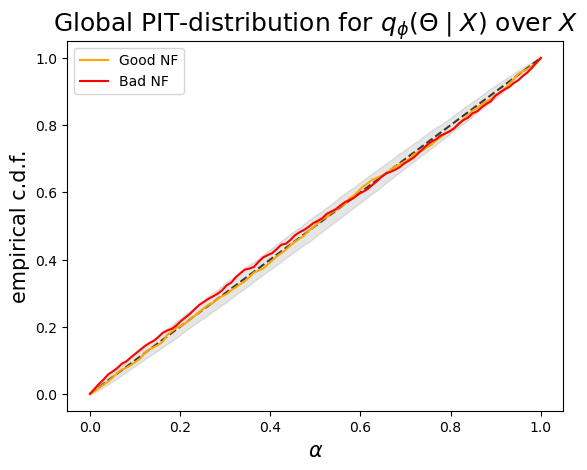

In [8]:
# PLOT GLOBAL/EXPECTED PIT-DISTRIBUTION of the trained estimators
from diagnostics.pp_plots import PP_plot_1D, cde_pit_values_zuko
from data.feature_transforms import first_dim_only

# Compute PIT-values of the flows F_{Q|X_i}(Theta_i)
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)]
flow_joint_pit_values_good = cde_pit_values_zuko(
    theta_test, x_test, maf_good.flow
)
# [PIT(Theta_i, X_i, maf_bad) = F_{Q_bad|X_i}(Theta_i)]
flow_joint_pit_values_bad = cde_pit_values_zuko(

    theta_test, first_dim_only(x_test), maf_bad.flow
)

# PP-plot of global PIT-distribution for both flows
# alpha-quantiles = [P_X,Theta(Z < alpha)]
alphas = np.linspace(0,1,100)
PP_plot_1D(
    PIT_values=[flow_joint_pit_values_good, flow_joint_pit_values_bad],
    alphas=alphas,
    colors=["orange", "red"],
    labels=["Good NF", "Bad NF"],
    title=r"Global PIT-distribution for $q_{\phi}(\Theta \mid X)$ over $X$",
    confidence_int=True,
    ylabel="empirical c.d.f."
)

#### 2. Local Consistency
We evaluate the true target density and the trained estimators in $x_0 = [0,1]$.

#### True and estimated densities at $x_0$

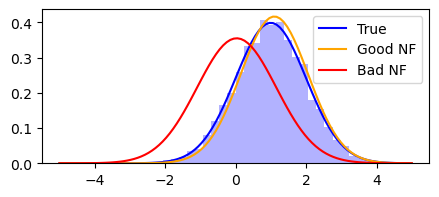

In [74]:
# Samples from the conditional distribution Theta|X=x_0
from scipy.stats import norm

x_0 = torch.FloatTensor([[0, 1]])

samples_theta_x_0 = torch.FloatTensor(
    [data_gen.sample_theta(x_0) for i in range(len(x_cal))]
).reshape(-1, 1)

dist_theta_x_0 = norm(loc=1,scale=1)

# Plot PDF of trained flows evaluated in x_0
flows = {"Good MAF": (maf_good.flow, x_0, "orange"), "Bad MAF": (maf_bad.flow, x_0[:, 0], "red")}
grid = torch.linspace(-5,5,100).reshape(-1,1)
plt.figure(figsize=(5,2))
plt.plot(grid.numpy(), dist_theta_x_0.pdf(grid.numpy()), label='True', color='blue')
plt.hist(samples_theta_x_0.numpy(), bins=30, density=True, color='blue', alpha=0.3)
plt.plot(grid.numpy(), maf_good.flow(x_0).log_prob(grid).detach().exp(), color='orange', label='Good NF')
plt.plot(grid.numpy(), maf_bad.flow(first_dim_only(x_0)).log_prob(grid).detach().exp(), color='red', label='Bad NF')
plt.legend()
# plt.xlabel(r'$\theta$')
# plt.ylabel(r'$p(\theta \mid x_0)$')
# plt.title(r"p.d.f. at $x_0 = (0,1)$")
plt.show()


- bad maf: negative bias and a little overdispersed
- good maf: seems fine, just a little positive bias.

This is can also be seen in the local PIT distribution that we can compute as a reference using the samples from the "true" target density at $x_0$, $p(\theta \mid x_0)$:

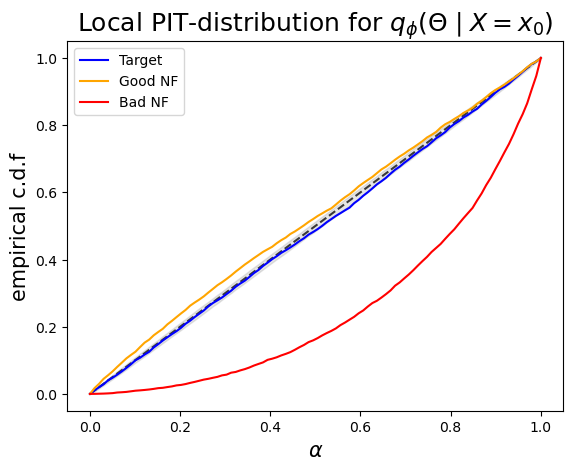

In [13]:
# Local PIT-distribution on samples Theta_{0,i} ~ Theta|X=x_0

# Compute PIT-values [PIT(Theta_{0,i}, X=x_0, p_true/good/bad) = F_{true/good/bad|x_0}(Theta_{0,i})]
true_local_pit_values = data_gen.true_pit_values(samples_theta_x_0, x_0, local=True)
flow_local_pit_values_good = cde_pit_values_zuko(
    samples_theta_x_0, x_0.repeat(5000,1), flow=maf_good.flow, 
)
flow_local_pit_values_bad = cde_pit_values_zuko(
    samples_theta_x_0, first_dim_only(x_0.repeat(5000,1)), flow=maf_bad.flow, 
)

# PP-plot of the local distribution
# alpha-quantiles = [P_{Theta|X}(Z < alpha)]
PP_plot_1D(
    PIT_values=[
        true_local_pit_values,
        flow_local_pit_values_good,
        flow_local_pit_values_bad,
    ],
    alphas=alphas,
    colors=["blue", "orange", "red"],
    labels=["Target", "Good NF", "Bad NF"],
    title=r"Local PIT-distribution for $q_{\phi}({\Theta \mid X=x_0)}$",
    confidence_int=True,
    ylabel="empirical c.d.f"
)

#### Local C2ST at $x_0$

##### Cross-val Score 
We predict probas as $x_0$ and evaluate different metrics over all cross-val folds.


In [14]:
from diagnostics.localC2ST import score_lc2st_flow_zuko
from diagnostics.localC2ST import score_lc2st

# # clf kwargs like in sbi.utils.metrics c2st function 

# ndim = 3 # clf_feature dim = (theta_dim + x_dim)
# clf_kwargs = {
#     "activation": "relu",
#     "hidden_layer_sizes": (10 * ndim, 10 * ndim),
#     "max_iter": 1000,
#     "solver": "adam",
#     "early_stopping": True,
#     "n_iter_no_change": 50,
# }
clf_kwargs = {}

scores_good, probas_good = score_lc2st_flow_zuko(
    maf_good.flow, theta_cal, x_cal, x_0, metrics=["mean", "w_dist", "TV"], n_folds=10, clf_kwargs=clf_kwargs,
)
scores_bad, probas_bad = score_lc2st_flow_zuko(
    maf_bad.flow, theta_cal, x_cal, x_0, metrics=["mean", "w_dist", "TV"], n_folds=10, clf_kwargs=clf_kwargs,
)

base_dist_samples = maf_good.flow(x_cal).base.sample()
scores_null, probas_null_cv = score_lc2st(
    P=base_dist_samples,
    Q=base_dist_samples,
    x_cal=x_cal,
    x_eval=x_0,
    metrics=["mean", "w_dist", "TV"],
    n_folds=10,
    clf_kwargs=clf_kwargs,
)

In [15]:
print('mean:')
print('good:', np.mean(scores_good['mean']).__round__(2), '+/-', np.std(scores_good['mean']).__round__(2))
print('bad:', np.mean(scores_bad['mean']).__round__(2), '+/-', np.std(scores_bad['mean']).__round__(2))
print('null:', np.mean(scores_null['mean']).__round__(2), '+/-', np.std(scores_null['mean']).__round__(2))

print()
print('w_dist:')
print('good:', np.mean(scores_good['w_dist']).__round__(2), '+/-', np.std(scores_good['w_dist']).__round__(2))
print('bad:', np.mean(scores_bad['w_dist']).__round__(2), '+/-', np.std(scores_bad['w_dist']).__round__(2))
print('null:', np.mean(scores_null['w_dist']).__round__(2), '+/-', np.std(scores_null['w_dist']).__round__(2))

print()
print('TV:')
print('good:', np.mean(scores_good['TV']).__round__(2), '+/-', np.std(scores_good['TV']).__round__(2))
print('bad:', np.mean(scores_bad['TV']).__round__(2), '+/-', np.std(scores_bad['TV']).__round__(2))
print('null:', np.mean(scores_null['TV']).__round__(2), '+/-', np.std(scores_null['TV']).__round__(2))


mean:
good: 5e-01 +/- 0.01
bad: 0.58 +/- 0.01
null: 0.5 +/- 0.01

w_dist:
good: 0.03 +/- 0.0
bad: 0.2 +/- 0.01
null: 0.01 +/- 0.0

TV:
good: 0.01 +/- 0.0
bad: 0.08 +/- 0.01
null: 0.0 +/- 0.0


##### Plot histograms 

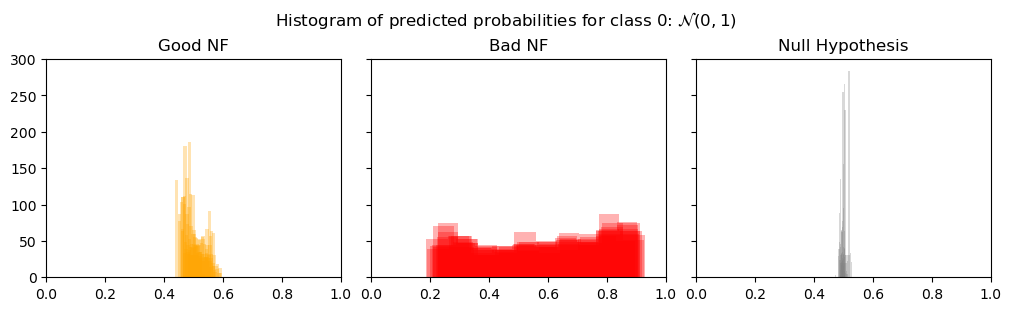

In [16]:
n_trials = 10
fig, axs = plt.subplots(1,3, figsize=(10, 3), constrained_layout=True, sharey=True)
for t in range(n_trials):
    axs[0].hist(probas_good[t],alpha=0.3, color='orange')
    axs[1].hist(probas_bad[t],alpha=0.3, color='red')
    axs[2].hist(probas_null_cv[t],alpha=0.3, color='grey')
axs[0].set_xlim(0,1)
axs[0].set_ylim(0,300)
axs[0].set_title('Good NF')
axs[1].set_xlim(0,1)
axs[1].set_ylim(0,300)
axs[1].set_title('Bad NF')
axs[2].set_xlim(0,1)
axs[2].set_ylim(0,300)
axs[2].set_title('Null Hypothesis')
plt.suptitle(r'Histogram of predicted probabilities for class 0: $\mathcal{N}(0,1)$')
plt.show()


##### Hyptothesis Test Diagnostics (evaluate w.r.t null-hypothesis)

In [18]:
from diagnostics.localC2ST import test_lc2st

P_eval = maf_good.flow(x_0[0]).base.sample((len(x_test),))
null_dist = maf_good.flow(x_0[0]).base
metrics = ["mean", "w_dist", "TV"]

# ndim = 3  # clf_feature dim = (theta_dim + x_dim)
# clf_kwargs = {
#     "activation": "relu",
#     "hidden_layer_sizes": (10 * ndim, 10 * ndim),
#     "max_iter": 1000,
#     "solver": "adam",
#     "early_stopping": True,
#     "n_iter_no_change": 50,
# }
clf_kwargs = {}

p_values_good, test_stats_good, probas_good_ens, probas_null, t_stats_null = test_lc2st(
    base_dist_samples,
    inv_flow_samples_cal_good,
    x_cal,
    P_eval,
    x_eval=x_0,
    null_dist=null_dist,
    test_stats=metrics,
    clf_kwargs=clf_kwargs,
    n_trials_null=100
)

p_values_bad, test_stats_bad, probas_bad_ens, _, _ = test_lc2st(
    base_dist_samples,
    inv_flow_samples_cal_bad,
    x_cal,
    P_eval,
    x_eval=x_0,
    null_dist=null_dist,
    test_stats=metrics,
    clf_kwargs=clf_kwargs,
    probas_null=probas_null
)

In [19]:
p_values_good, p_values_bad

({'mean': 0.42, 'w_dist': 0.03, 'TV': 0.21},
 {'mean': 0.0, 'w_dist': 0.0, 'TV': 0.0})

1. Mean predicted proba for class 0

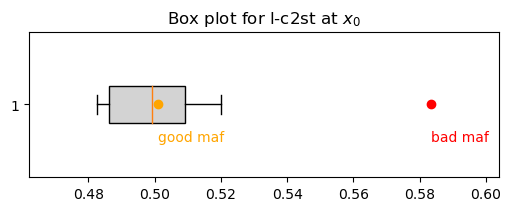

pvalues: 0.42 0.0


In [20]:
from diagnostics.localC2ST import box_plot_lc2st

box_plot_lc2st(
    [test_stats_good["mean"], test_stats_bad["mean"]],
    t_stats_null["mean"],
    labels=["good maf", "bad maf"],
    colors=["orange", "red"],
)

print('pvalues:', p_values_good['mean'], p_values_bad['mean'])

2. Wasserstein distance (w_dist) between dirac and predicted probas for class 0

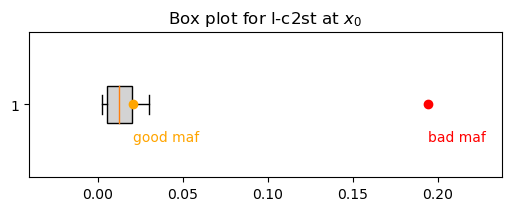

pvalues: 0.03 0.0


In [21]:
box_plot_lc2st(
    [test_stats_good["w_dist"], test_stats_bad["w_dist"]],
    t_stats_null["w_dist"],
    labels=["good maf", "bad maf"],
    colors=["orange", "red"],
)
print("pvalues:", p_values_good["w_dist"], p_values_bad["w_dist"])

3. Total variation (TV): distribution (c.d.f.) of predicted probas 

The associated test-statistic (TV_dist) is the euclidean distance to the c.d.f of the dirac function at $0.5$ (step function in black dashed line).

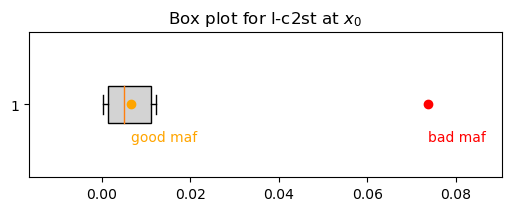

pvalues: 0.21 0.0


In [22]:
box_plot_lc2st(
    [test_stats_good["TV"], test_stats_bad["TV"]],
    t_stats_null["TV"],
    labels=["good maf", "bad maf"],
    colors=["orange", "red"],
)
print("pvalues:", p_values_good["TV"], p_values_bad["TV"])

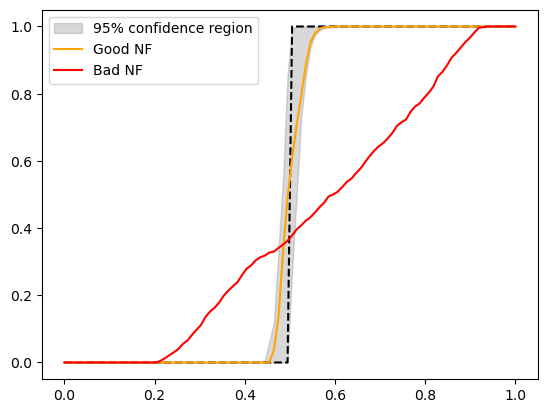

In [23]:
from diagnostics.localC2ST import pp_plot_lc2st
pp_plot_lc2st([probas_good_ens, probas_bad_ens], probas_null, labels=['Good NF', 'Bad NF'], colors=['orange', 'red'])

#### Interpretability: where can the classifier discriminate (or not)?
(cf. [Lee et al. (2018)])

The distributions we which to compare with this local C2ST test are the $p(z \mid x_0)$ where $z = T_{\phi}^{-1}(\theta; x_0)$ or $z \sim \mathcal{N}(0,1)$
- the true distribution at $x_0$ of the inverse transformation at $x_0$ (for good and bad maf): $p(T_{\phi}^{-1}(\theta; x_0)\mid x_0)$
- the normal distribution $\mathcal{N}(0,1)$

Using the samples from the true conditional distribution $p(\theta \mid x_0)$ (which we only have in this toy example and not in a regular sbi setting), we can get samples from the inverse transformations and plot the histograms.

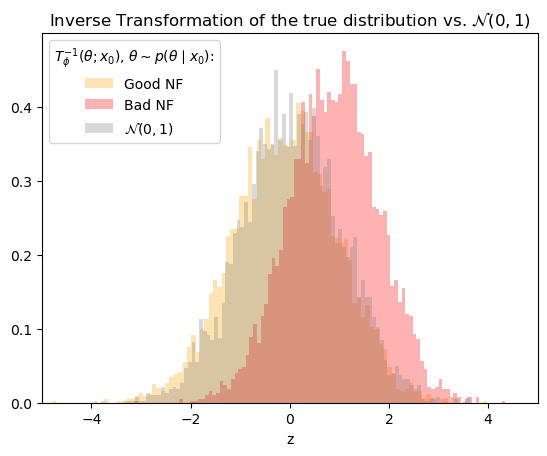

In [38]:
# Hist of the distributions: norm, inv-flow good/bad
inv_flow_samples_true_good = maf_good.flow(x_0).transform(samples_theta_x_0).detach().numpy()
inv_flow_samples_true_bad = maf_bad.flow(first_dim_only(x_0)).transform(samples_theta_x_0).detach().numpy()
plt.hist(inv_flow_samples_true_good, bins=100, color='orange', alpha=0.3, density=True, label='Good NF') 
plt.hist(inv_flow_samples_true_bad, bins = 100, color='red', alpha=0.3, density=True, label='Bad NF') 
plt.hist(base_dist_samples.numpy(), bins=100, color='grey', alpha=0.3, density=True, label=r'$\mathcal{N}(0,1)$') 

plt.legend(title= r'$T_{\phi}^{-1}(\theta;x_0)$, $\theta \sim p(\theta \mid x_0)$:' )
plt.title(r'Inverse Transformation of the true distribution vs. $\mathcal{N}(0,1)$')
plt.xlabel('z')
plt.xlim(-5,5)
plt.show()

This shows us what we should expect from our predicted probabilities: regions where the norm pdf (blue) nis higher than the other (orange or red), the predicted probas should be above 0.5, otherwise they should be below 0.5. 

It relates to the exact opposite case of what we saw in the pdf plot of the learned distributions at $x_0$: 
- negative bias becomes positive bias
- overdispersion becomes underdispersion

WHY? inverse transformation? always the case? just inverse affine transformation of the MAF...?


In [66]:
# train classifier and predict probas for x_0 over a grid
from diagnostics.localC2ST import train_lc2st, eval_lc2st
from sklearn.neural_network import MLPClassifier

grid = np.linspace(-5,5,1000)
null_samples = null_dist.sample((len(x_cal),))

n_trials = 10
probas_grid_good = []
probas_grid_bad = []
probas_grid_null = []

for t in range(n_trials): 
        # predict probas 
        # good and bad maf
        clf_good = train_lc2st(base_dist_samples, inv_flow_samples_cal_good, x_cal, clf=MLPClassifier(**clf_kwargs))
        probas_grid_good.append(eval_lc2st(grid.reshape(-1,1), x_0, clf=clf_good))
        
        clf_bad = train_lc2st(base_dist_samples, inv_flow_samples_cal_bad, x_cal, clf=MLPClassifier(**clf_kwargs))
        probas_grid_bad.append(eval_lc2st(grid.reshape(-1,1), x_0, clf=clf_bad))
        
        clf_null = train_lc2st(base_dist_samples, null_samples, x_cal, clf=MLPClassifier(**clf_kwargs))
        probas_grid_null.append(eval_lc2st(grid.reshape(-1,1), x_0, clf=clf_null))


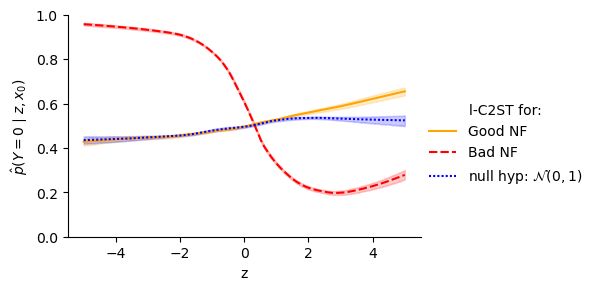

In [67]:
# plot predicted probas over grid
probas = np.concatenate(
    [
        np.concatenate(probas_grid_good),
        np.concatenate(probas_grid_bad),
        np.concatenate(probas_grid_null)
    ]
)
grids = np.concatenate([grid.reshape(-1,1)]*30)
names = [r'Good NF']*10000+[r'Bad NF']*10000+ [r'null hyp: $\mathcal{N}(0,1)$']*10000

df = pd.DataFrame({r'l-C2ST for:': names, r'$\hat{p}(Y=0 \mid z,x_0)$': probas, 'z': grids[:,0]})

import seaborn as sns

g = sns.relplot(
        data=df, x="z", y=r"$\hat{p}(Y=0 \mid z,x_0)$",
        hue=r'l-C2ST for:', style=r'l-C2ST for:', kind="line", palette=['orange','red', 'blue'],
        height=3,
        aspect=1.5,
    )

plt.ylim(0,1)
plt.show()

Results:
- red (bad): high probas (>0.5) until $z\approx0.5$ (which is where the norm pdf is indeed higher) and low probas (<0.5) until the end (which is where the red pdf is higher) --> big negative bias
- orange (good): pretty close to 0.5 but tendency of "lower then higher" --> small positive bias 
- blue (norm/null): always around 0.5. (small border effects)

The location (and amplitude) of the peak of the low-probas indicates positive/negative (small/big) bias (in 1D at least). 

In higher dimensions we cannot talk/conclude about bias or over/underdispersion, but we can identify the regions where one or the other pdf in higher, and where they are equal. 

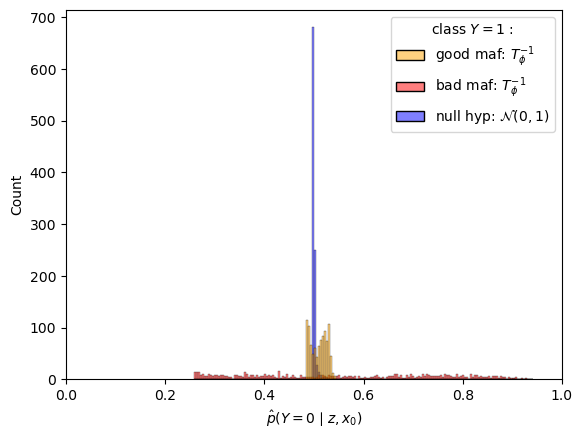

In [109]:
# plot predicted probas for x_0 
probas_z = np.concatenate(
    [
        probas_good_ens,
        probas_bad_ens,
        np.mean(probas_null, axis=0),
    ]
)
# grids = np.concatenate([grid.reshape(-1,1)]*30)
names = [r'good maf: $T^{-1}_{\phi}$']*1000+[r'bad maf: $T^{-1}_{\phi}$']*1000+[r'null hyp: $\mathcal{N}(0,1)$']*1000

df = pd.DataFrame({r'class $Y=1$ :': names, r'$\hat{p}(Y=0 \mid z,x_0)$': probas_z})

import seaborn as sns
sns.histplot(
        data=df, x=r"$\hat{p}(Y=0 \mid z,x_0)$",
        hue=r'class $Y=1$ :',  palette=['orange','red','grey']
)
plt.xlim(0,1)
plt.show()

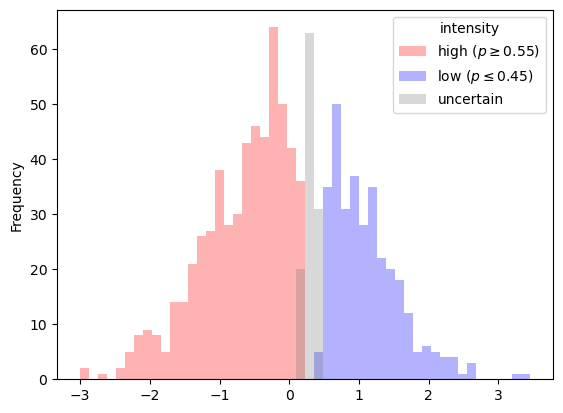

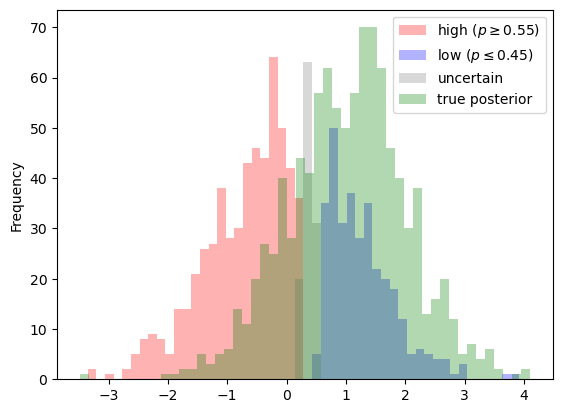

In [60]:
df_bad = pd.DataFrame({'z':P_eval[:,0], 'probas': probas_bad_ens})
# df[df['probas']>0.55]
df_bad['intensity'] = ['uncertain']*len(df_bad)
df_bad.loc[df_bad['probas']>0.55, 'intensity'] = r'high ($p \geq 0.55$)'
df_bad.loc[df_bad['probas']<0.45, 'intensity'] = r'low ($p \leq 0.45$)'
df_bad.pivot(columns='intensity', values='z').plot.hist(bins=50, color=['red','blue','grey'], alpha=0.3)

fwd_flow = maf_bad.flow(x_0).transform.inv(torch.FloatTensor(P_eval).reshape(-1,1)).detach().numpy()

df_bad['theta'] = fwd_flow
df_bad.pivot(columns='intensity', values='theta').plot.hist(bins=50, color=['red','blue','grey'], alpha=0.3)
plt.hist(samples_theta_x_0.numpy()[:1000], color='green', alpha=0.3, bins=50, label='true posterior')
plt.legend()
plt.show()

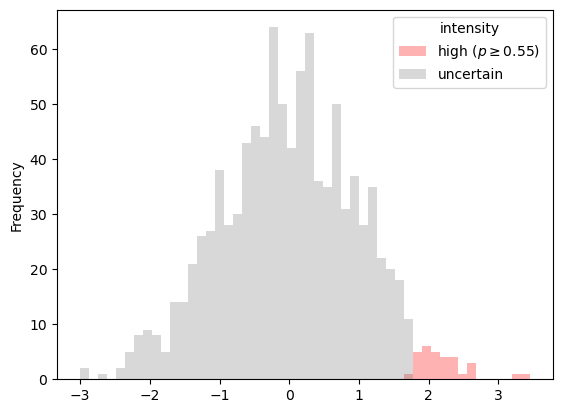

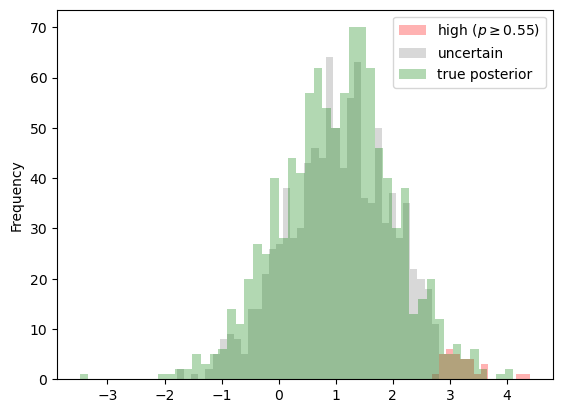

In [61]:
df_good = pd.DataFrame({'z':P_eval[:,0], 'probas': probas_good_ens})
# df[df['probas']>0.55]
df_good['intensity'] = ['uncertain']*len(df_good)
df_good.loc[df_good['probas']>0.55, 'intensity'] = r'high ($p \geq 0.55$)'
df_good.loc[df_good['probas']<0.45, 'intensity'] = 'low'
df_good.pivot(columns='intensity', values='z').plot.hist(bins=50, color=['red','grey', 'blue'], alpha=0.3)
plt.show()

fwd_flow = maf_good.flow(x_0).transform.inv(torch.FloatTensor(P_eval).reshape(-1,1)).detach().numpy()

df_good['theta'] = fwd_flow
df_good.pivot(columns='intensity', values='theta').plot.hist(bins=50, color=['red','grey', 'blue'], alpha=0.3)
plt.hist(samples_theta_x_0.numpy()[:1000], color='green', alpha=0.3, bins=50, label='true posterior')
plt.legend()
plt.show()

### Choice of classification model cal-set size

#### Accuracy - Shift experiment - Model choice
We compute the global cross-val lc2st score (mean of predicted probabilities ~ accuracy) between two 1D gaussians: 
- Reference: $\quad \mathcal{N}(0,1)$
- Gaussian with shifted mean or std: $\quad \mathcal{N}(m,1), m \in [0,10] \quad$ or $\quad \mathcal{N}(0,s), s \in [1,20]$

The classifiers are trained on samples of the joint: $[z_i, x_i]$ where the $z_i$ correspond to samples from the reference or the other gaussian distribution with lables 0 or 1.

The ground truth (i.e objectively best discriminator which recovers the analytic response) is obtained via LDA (resp. QDA) in the mean-shift (resp. scale-shift) experiment.

*Comment: If several classifiers have similar permormance, we can also look at the total cv time.*

##### Experimental SET-UP

In [6]:
import torch.distributions as D

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

N_list = [1000, 2000, 5000]
mean_shifts = [0, 0.3, 0.6, 1, 1.5, 2, 2.5, 3, 5, 10]
scale_shifts = np.linspace(1, 20, 10)

# Datasets
x_samples = {}
ref_samples = {}
for n in N_list:
    x_samples[n] = data_gen.sample_x(n)
    ref_samples[n] = D.MultivariateNormal(
        loc=torch.zeros(1), covariance_matrix=torch.eye(1)
    ).rsample((n,))

mean_shifted_samples = {}
scale_shifted_samples = {}
for n in N_list:
    mean_shifted_samples[n] = [
        D.MultivariateNormal(
            loc=torch.FloatTensor([m]), covariance_matrix=torch.eye(1)
        ).rsample((n,))
        for m in mean_shifts
    ]
    scale_shifted_samples[n] = [
        D.MultivariateNormal(
            loc=torch.zeros(1), covariance_matrix=torch.eye(1) * s
        ).rsample((n,))
        for s in scale_shifts
    ]

# Models
ndim = x_samples[1000].shape[-1] + ref_samples[1000].shape[-1]
clf_classes = {
    "mlp_base": MLPClassifier,
    "mlp_sbi": MLPClassifier,
    "rf": RandomForestClassifier,
    "logreg": LogisticRegression,
    "lda": LinearDiscriminantAnalysis,
    "qda": QuadraticDiscriminantAnalysis,
}
clf_kwargs_dict = {
    "mlp_base": {},
    "mlp_sbi": {
        "activation": "relu",
        "hidden_layer_sizes": (10 * ndim, 10 * ndim),
        "max_iter": 1000,
        "solver": "adam",
        "early_stopping": True,
        "n_iter_no_change": 50,
    },
    "rf": {},
    "logreg": {},
    "lda": {},
    "qda": {},
}

##### Mean Shifts

In [7]:
from diagnostics.localC2ST import eval_classifier_for_lc2st

clf_names = ["lda", "mlp_sbi", "mlp_base", "rf", "logreg"]

dfs_mean = {}
for n in N_list:
    dfs = []
    for clf_name in clf_names:
        shift_list, scores, times = eval_classifier_for_lc2st(
            x_samples[n],
            ref_samples[n],
            shifted_samples=mean_shifted_samples[n],
            shifts=mean_shifts,
            clf_class=clf_classes[clf_name],
            clf_kwargs=clf_kwargs_dict[clf_name],
        )
        clf_method = [clf_name]*len(shift_list)
        dfs.append(pd.DataFrame({'mean_shift': shift_list, 'accuracy': scores, 'total_cv_time':times, 'classifier':clf_method}))
    dfs_mean[n] = pd.concat(dfs, ignore_index=True)

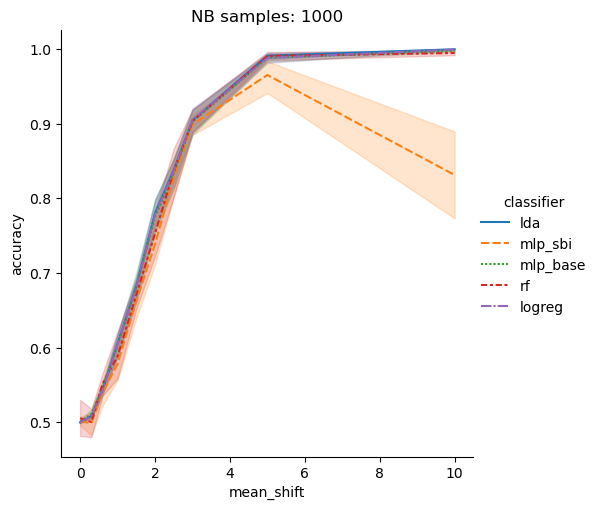

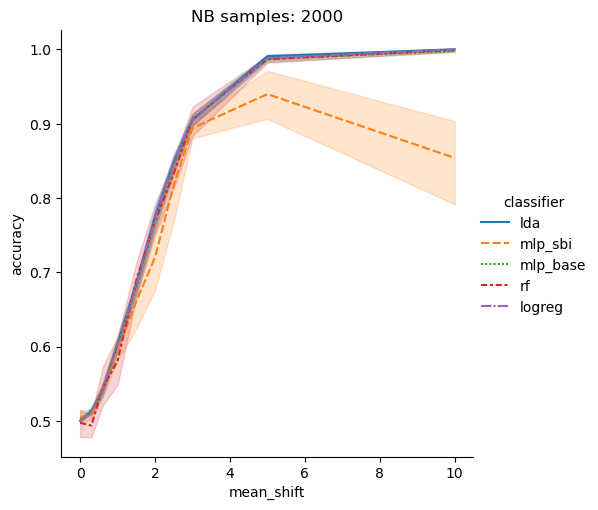

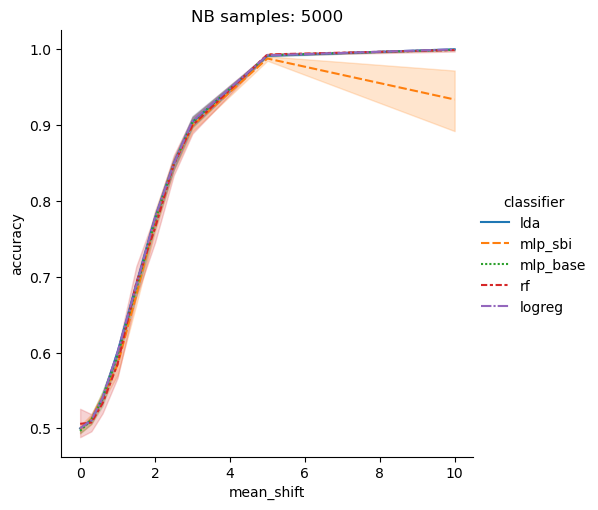

In [8]:
dfs_mean = torch.load('../saved_experiments/Gaussian1d/lc2st_eval_clfs/dfs_mean_proba_mean.pkl')

import seaborn as sns
for n in N_list:
    sns.relplot(
        data=dfs_mean[n], x="mean_shift", y="accuracy",
        hue="classifier", style="classifier", kind="line",
    )
    plt.title(f'NB samples: {n}')
    plt.show()

##### Scale Shifts

In [9]:
clf_names = ["qda", "mlp_sbi", "mlp_base", "rf", "logreg"]

dfs_scale = {}
for n in N_list:
    dfs = []
    for clf_name in clf_names:
        shift_list, scores, times = eval_classifier_for_lc2st(
            x_samples[n],
            ref_samples[n],
            shifted_samples=scale_shifted_samples[n],
            shifts=scale_shifts,
            clf_class=clf_classes[clf_name],
            clf_kwargs=clf_kwargs_dict[clf_name],
        )
        clf_method = [clf_name]*len(shift_list)
        dfs.append(pd.DataFrame({'scale_shift': shift_list, 'accuracy': scores, 'total_cv_time':times, 'classifier':clf_method}))
    dfs_scale[n] = pd.concat(dfs, ignore_index=True)

/data/parietal/store/work/jlinhart/miniconda3/envs/sdbm/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/parietal/store/work/jlinhart/miniconda3/envs/sdbm/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/parietal/store/work/jlinhart/miniconda3/envs/sdbm/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


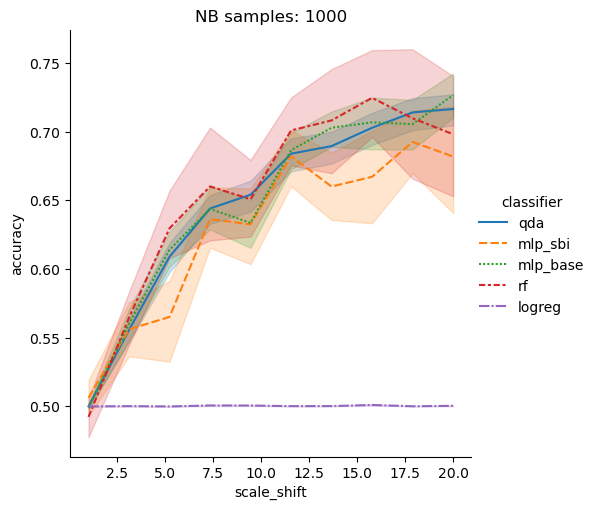

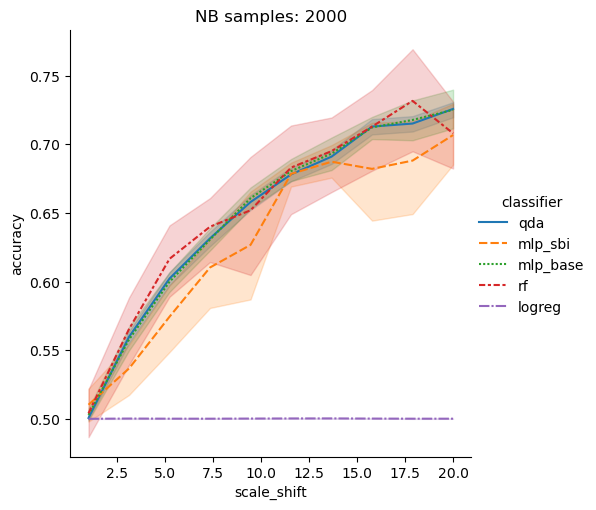

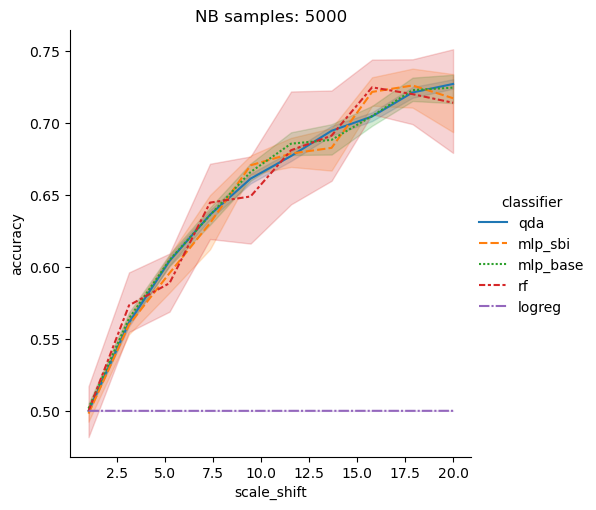

In [10]:
dfs_sacle = torch.load('../saved_experiments/Gaussian1d/lc2st_eval_clfs/dfs_scale_proba_mean.pkl')

for n in N_list:
    sns.relplot(
        data=dfs_scale[n], x="scale_shift", y="accuracy",
        hue="classifier", style="classifier", kind="line",
    )
    plt.title(f'NB samples: {n}')
    plt.show()

### Precision under the null hypothesis - cal set size 

For different cal set sizes we compute the cross-val test statistics (distance to dirac c.d.f) and stds of the predicted distribution (output of `eval_local_flow_c2st`) under the null hypothesis.

We relax the problem from a dirac to a gaussian distribution with std of 0.05 or 0.1 (smooth dirac):
- we compute the theoretical test-statistics of those two gaussians 
- we compare the obtained test-statistics and stds of the cross-validation to these theoretical values

#### Theoretical Test-stats for chosen stds

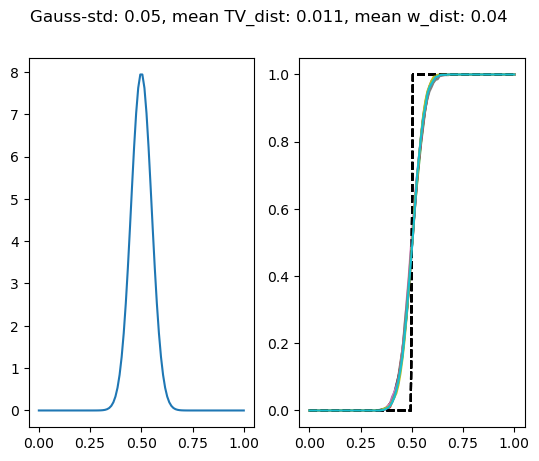

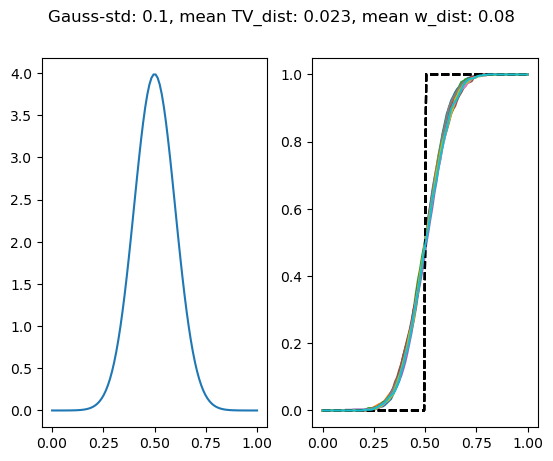

In [5]:
from diagnostics.pp_plots import PP_vals
from scipy.stats import wasserstein_distance, norm

def smooth_dirac(eps=0.1):
    return norm(loc=0.5,scale=eps)

alphas = np.linspace(0,1,100)
pp_vals_dirac = PP_vals([0.5]*1000, alphas)
for e in [0.05, 0.1]:
    fig, axs = plt.subplots(1,2)
    axs[0].plot(alphas,[smooth_dirac(eps=e).pdf(x) for x in alphas])

    pp_vals_dirac = PP_vals([0.5]*1000, alphas)

    test_stats = []
    w_dist = []
    for t in range(10):
        samples = smooth_dirac(eps=e).rvs(1000)
        pp_vals = pd.Series(PP_vals(samples, alphas))
        test_stats.append(((pp_vals - pp_vals_dirac) ** 2).sum() / len(alphas))
        w_dist.append(wasserstein_distance([0.5]*1000, samples))
        axs[1].plot(alphas, pp_vals_dirac, '--', color='black')
        axs[1].plot(alphas, pp_vals)
    plt.suptitle(f'Gauss-std: {e}, mean TV_dist: {np.round(np.mean(test_stats),3)}, mean w_dist: {np.round(np.mean(w_dist),3)}')
    plt.show()

In [22]:
from sklearn.model_selection import KFold
import time
from diagnostics.localC2ST import compute_metric, train_lc2st, eval_lc2st

def eval_null_lc2st(x_samples, null_dist, classifier, test_stats = ['mean'], n=1000, n_folds=10):
    
    nb_samples = []
    probas_stds = []
    scores = {}
    for m in test_stats:
        scores[m] = []
    times = []

    
    P = null_dist.sample((n,))
    Q = null_dist.sample((n,))
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)
    start = time.time()
    for t, (train_index, eval_index) in enumerate(kf.split(x_samples[n])):
        x_train = x_samples[n][train_index]
        x_eval = x_samples[n][eval_index]
        Q_train = Q[train_index]
        P_train = P[train_index]
        P_eval = P[eval_index]

        clf = train_lc2st(P_train, Q_train, x_train, clf=classifier)
    
        std_x = []
        for i,x_obs in enumerate(x_eval):
            proba = eval_lc2st(P_eval, x_obs, clf)
            scores_x = compute_metric(proba, metrics=test_stats)
            std_x.append(np.std(proba))
        
        probas_stds.append(np.mean(std_x))
        for m in test_stats:
            scores[m].append(np.mean(scores_x[m]))
        nb_samples.append(n)

    total_cv_time = time.time() - start
    for t in range(n_folds):
        times.append(total_cv_time)

    df = pd.DataFrame({f'nb_samples': nb_samples, 'probas_std': probas_stds, 'total_cv_time':times, 'classifier': ['mlp_sbi']*len(times)})
    for m in test_stats:
        df[m] = scores[m]

    return df

In [23]:
N_LIST = [1000, 2000, 5000, 10000]

data_gen = ConditionalGaussian1d()
x_samples = {}
for n in N_LIST:
    x_samples[n], _ = data_gen.get_joint_data(n=n)

null_dist = maf_good.flow(x_cal[0]).base

ndim = 3  # clf_feature dim = (theta_dim + x_dim)
clf_kwargs = {
    "activation": "relu",
    "hidden_layer_sizes": (10 * ndim, 10 * ndim),
    "max_iter": 1000,
    "solver": "adam",
    "early_stopping": True,
    "n_iter_no_change": 50,
}

from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(**clf_kwargs)

In [24]:
dfs = []
for n in N_LIST:
    dfs.append(eval_null_lc2st(x_samples, null_dist, classifier, test_stats = ['mean', 'w_dist', 'TV'], n=n, n_folds=50))

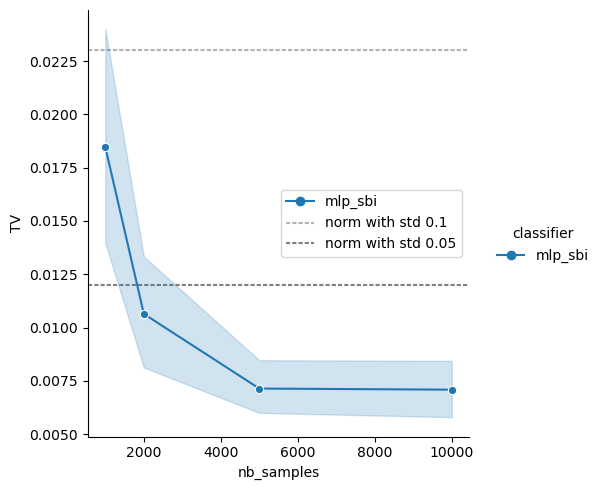

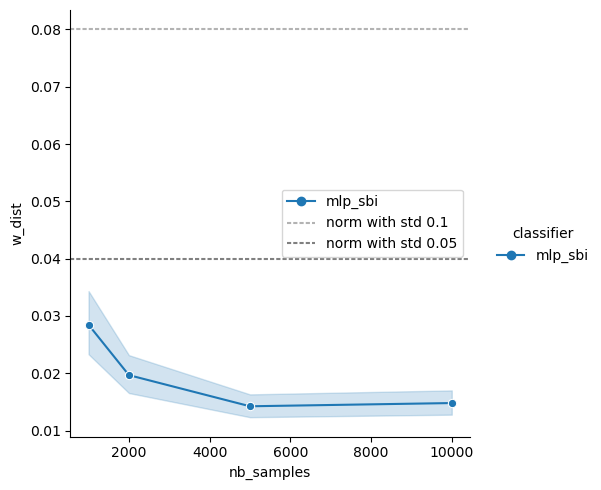

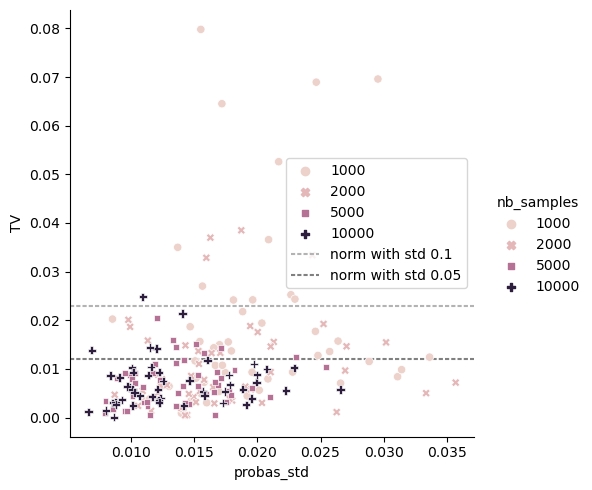

0.03568161651492119 0.03568161651492119


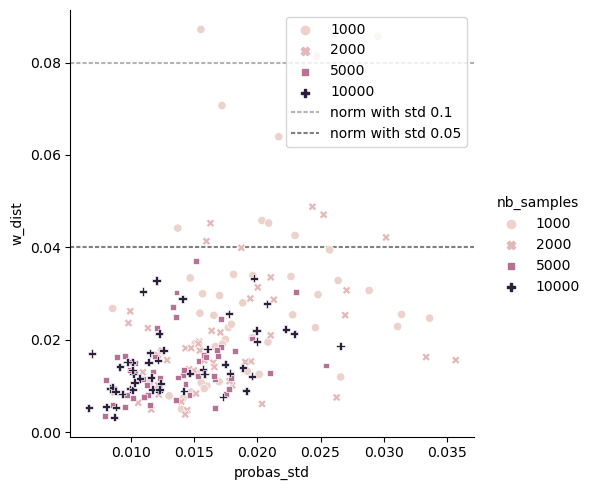

0.03568161651492119 0.03568161651492119


In [25]:
import seaborn as sns

df = pd.concat(dfs, ignore_index=True)
for T, y1, y2 in zip(['TV', 'w_dist'], [0.023,0.08], [0.012, 0.04]):
    g = sns.relplot(
            data=df, x="nb_samples", y=T,
            hue="classifier", style="classifier", kind="line", markers='o'
        )
    g.map(plt.axhline, y=y1, color=".7", dashes=(2, 1), zorder=0, label='norm with std 0.1')
    g.map(plt.axhline, y=y2, color=".5", dashes=(2, 1), zorder=0, label='norm with std 0.05')
    plt.legend()
    plt.show()


for T, y1, y2 in zip(['TV', 'w_dist'], [0.023,0.08], [0.012, 0.04]):
    g = sns.relplot(
            data=df, x="probas_std", y=T,
            hue="nb_samples", style="nb_samples", kind="scatter", 
        )
    g.map(plt.axhline, y=y1, color=".7", dashes=(2, 1), zorder=0, label='norm with std 0.1')
    g.map(plt.axhline, y=y2, color=".5", dashes=(2, 1), zorder=0, label='norm with std 0.05')
    plt.legend()
    plt.show()
    print(df[df[T]<=y1]['probas_std'].max(), df[df[T]<=y2]['probas_std'].max())